In [31]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 200
plt.rcParams["text.usetex"] = True

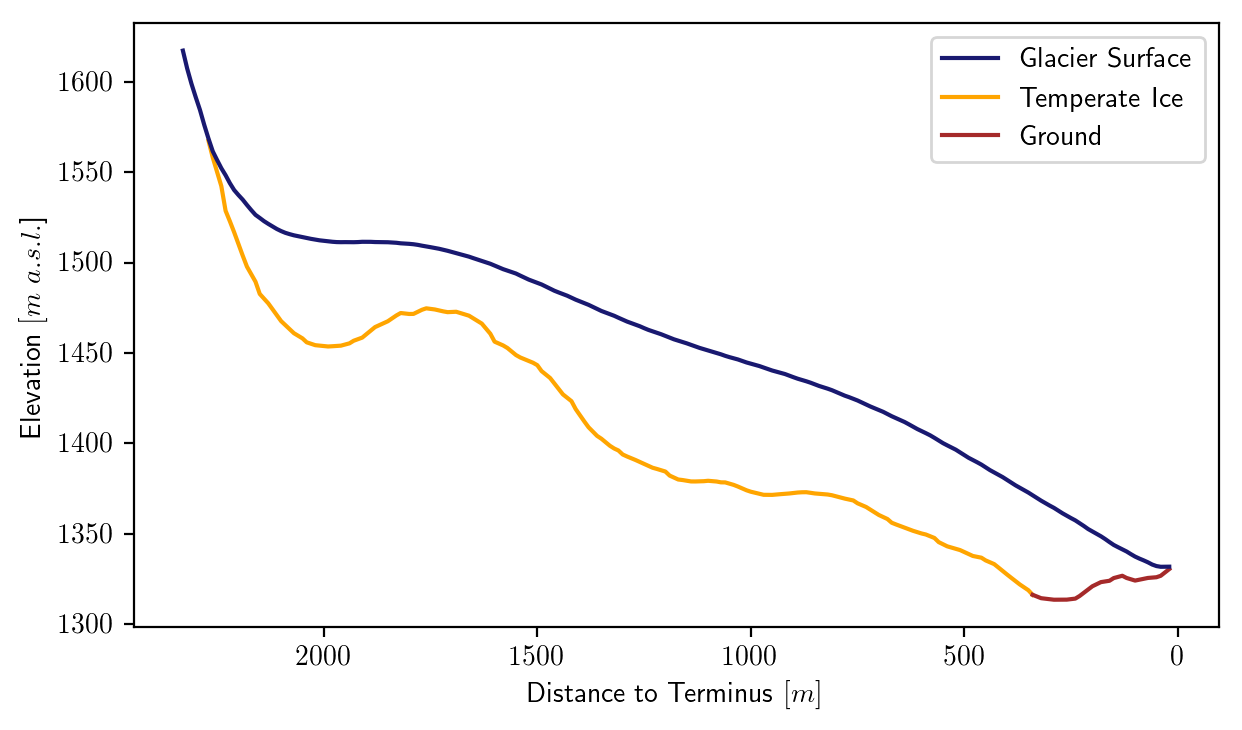

In [54]:
data = pd.read_csv("profile_180510.csv")
data.index *= 10
data = data.rolling(3).mean()

# Last 36 points are ground. Rest is temperate ice
data["ground"] = data["surface"].iloc[:35]
data["surface"] = data["surface"].iloc[34:]  # With some visually good overlap

# Remove values where temperate is higher than glacier
data["surface"] = data["surface"][data["surface"] < data["glacier"]]

plt.figure(figsize=(7, 4))

colors = ["midnightblue", "orange", "brown"]
labels = ["Glacier Surface", "Temperate Ice", "Ground"]
zorders = [3, 1, 2]

for i, col in enumerate(["glacier", "surface", "ground"]):
    plt.plot(data[col], c=colors[i], zorder=zorders[i], label=labels[i])

plt.ylabel("Elevation $[m\ a.s.l.$]")
plt.xlabel("Distance to Terminus $[m]$")
plt.legend()
plt.gca().invert_xaxis()

plt.savefig("export/cross_section_180510", dpi=300)